 # Apply the artistic style of one image (e.g., a famous painting) to the content of another image using neural style transfer.

Reference:
1. https://www.tensorflow.org/tutorials/generative/style_transfer
2. https://www.geeksforgeeks.org/neural-style-transfer-with-tensorflow/
3. https://towardsdatascience.com/how-do-neural-style-transfers-work-b76de101eb3?gi=876d3085e76d

In [8]:
# === Import Required Libraries ===
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import os
from tkinter import Tk, filedialog

In [9]:
# === Utility Functions ===
def load_img_from_path(path, max_dim=512):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [10]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [11]:
# === Upload Images ===
from google.colab import files

print("Upload Content Image:")
content_uploaded = files.upload()
content_path = list(content_uploaded.keys())[0]

Upload Content Image:


Saving Content.png to Content.png


In [12]:
print("Upload Style Image:")
style_uploaded = files.upload()
style_path = list(style_uploaded.keys())[0]

Upload Style Image:


Saving Style Img.png to Style Img.png


In [13]:
# === Load Content and Style Images ===
content_image = load_img_from_path(content_path)
style_image = load_img_from_path(style_path)

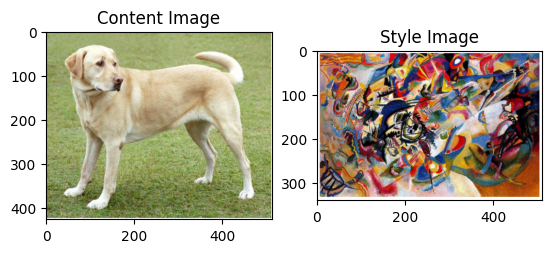

In [14]:
# === Display Images ===
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(content_image))
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(style_image))
plt.title('Style Image')
plt.show()

In [15]:
# === Load Pre-trained VGG19 ===
def vgg_layers(layer_names):
    """Creates a VGG model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [16]:
# Content and Style Layer Names (as per TensorFlow tutorial)
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [17]:
# === Extract Style and Content ===
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [18]:
# Gram Matrix for Style
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

In [19]:
# === Style Transfer Training ===
extractor = StyleContentModel(style_layers, content_layers)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 340, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 426, 512, 3))
  warnings.warn(msg)


In [21]:
# Generated image to optimize
image = tf.Variable(content_image)

In [22]:
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02)

In [23]:
# Weights
style_weight = 1e-2
content_weight = 1e4

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss

In [25]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

In [26]:
# === Run Style Transfer ===
import time

def stylize(image, steps=100):
    start = time.time()

    for n in range(steps):
        train_step(image)
        if n % 10 == 0:
            print(f"Step {n}")

    end = time.time()
    print(f"Total time: {end-start:.1f} sec")


stylize(image, steps=100)

Step 0
Step 10
Step 20
Step 30
Step 40
Step 50
Step 60
Step 70
Step 80
Step 90
Total time: 825.5 sec


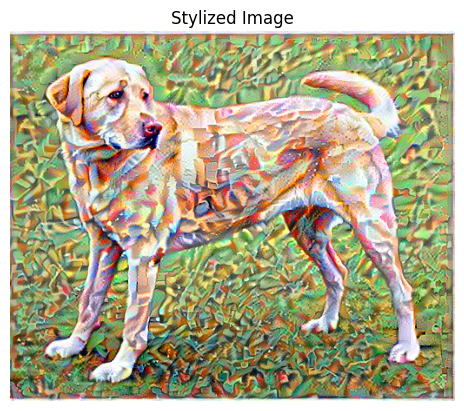

In [27]:
# === Show Result ===
final_img = tensor_to_image(image)
plt.imshow(final_img)
plt.title('Stylized Image')
plt.axis('off')
plt.show()

In [28]:
# Save result
final_img.save('stylized_result.jpg')